# **COMP 2211 Exploring Artificial Intelligence**
## Image Classification (CNN)

![animals.jpg](https://storage.googleapis.com/kaggle-datasets-images/1554380/2561346/c14cd64fb06842ad190298f9f4efaa49/dataset-cover.png?t=2021-08-26-19-14-08)

**Enable the GPU accelerator in Colab:**

***1. 'Edit' -> 'Notebook settings':***

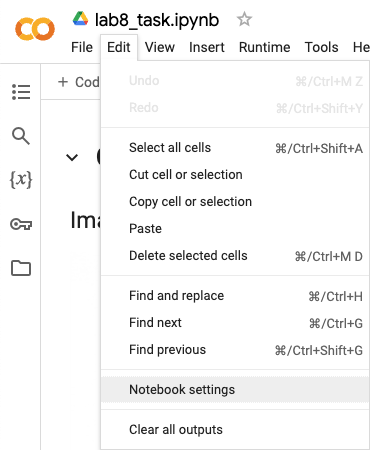

***2. Set 'Hardware accelerator' to 'GPU'***:

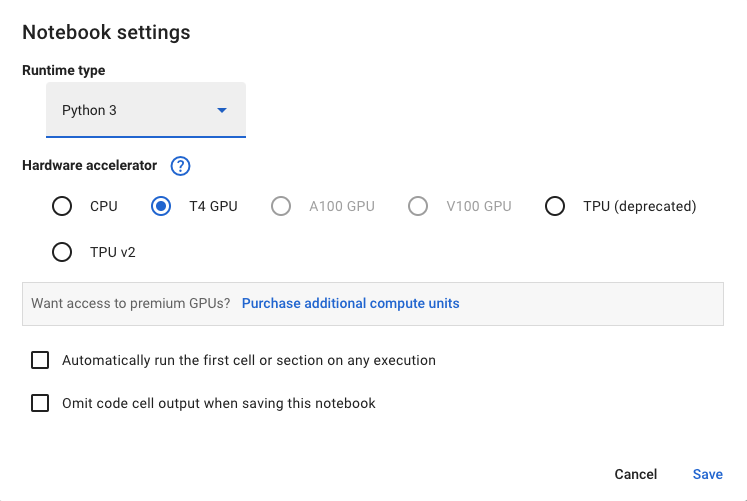

## Check if GPU is enabled

In [5]:
# check your Colab device
import tensorflow as tf  # Import tensorflow library
import pprint            # Import pprint library for better print format
device_name = tf.config.list_physical_devices()  # A list of divece name, which could contain CPU and GPU
pprint.pprint(device_name)                       # Print the device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***Note:*** If you use GPU too regularly, runtime durations will become shorter and shorter, and disconnections more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

## **Lab Task Procedure**
0. Data preparation
1. Data preprocessing
2. Data generator **(Task 1)**
3. Build the model **(Task 2)**
4. Compile the model
5. Train the model
6. Evaluate the model
7. Save the model

## **Data Preparation**


1. Download the [Animal Species Classification Dataset](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset) from [here](https://course.cse.ust.hk/comp2211/labs/lab8/files/animal_species_v3.zip).
2. Upload this data to your Google Drive, under folder `comp2211/lab8`.
3. Run the following code cell to mount Google Drive and unzip the data.

Note: If this lasts for more than three minutes, you may try deleting the previously unzipped folder on Google Drive and try again.



In [6]:
from google.colab import drive
drive.mount("/content/drive")
%cd "drive/MyDrive/comp2211/lab8"
!unzip -q -o animal_species_v3.zip -d .

In [7]:
import os
data_dir = './animal_species_v3/train'
category_list = sorted(os.listdir(data_dir))
print(category_list)
print('Total categories:', len(category_list))

['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']
Total categories: 15


## **Animal Recognition**
---
About the data:
- Number of images: **7,500**.
- Number of classes: **15**.
- Image size: **(64, 64, 3)**.

Before data preprocessing, we visualize some of the images to get familiar with the data.

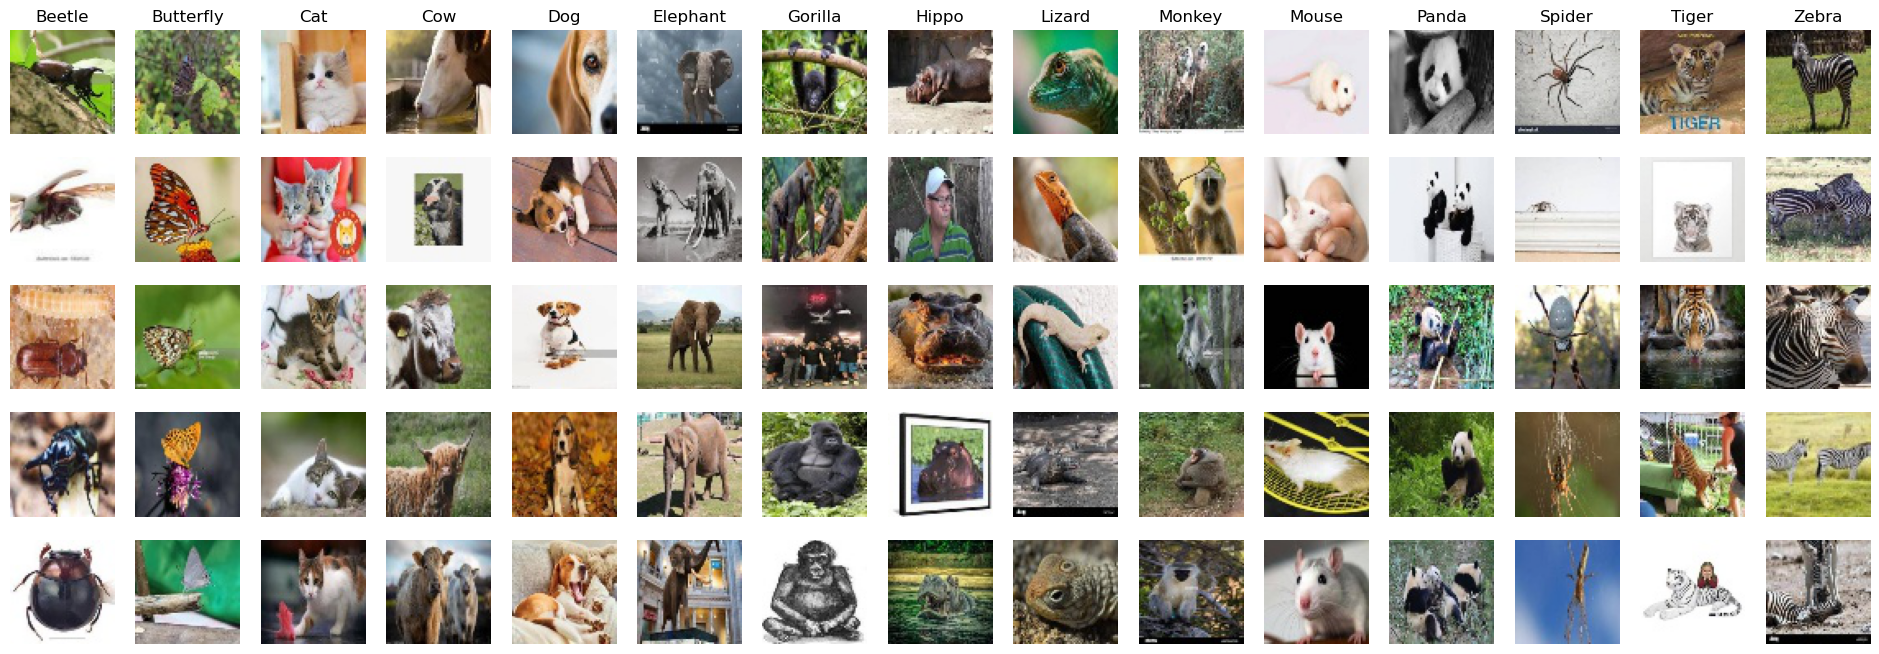

In [8]:
import os, cv2, random
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
for i, cate in enumerate(category_list):
  img_names = random.sample(os.listdir(data_dir+'/'+cate), k=5)
  for j, img_name in enumerate(img_names): # we only show 5 images of each category
    img = plt.imread(data_dir+'/'+cate+'/'+img_name) # read the image
    plt.subplot(5, 15, 15*j+i+1) # plot the same category at the same column
    plt.imshow(img)
    plt.axis('off')
    if j == 0: # only show category name at the first row
      plt.title(cate)
plt.show()


In [9]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint

## 1. Data preprocessing

We first construct a mapping from string-type category names to integer-type class indices, for later use.

In [10]:
# Create a dict mapping the category name to the class index
# The number of label should be 15 (0 to 14)
cate2Idx = {cate:idx for idx, cate in enumerate(category_list)}
print(cate2Idx)

{'Beetle': 0, 'Butterfly': 1, 'Cat': 2, 'Cow': 3, 'Dog': 4, 'Elephant': 5, 'Gorilla': 6, 'Hippo': 7, 'Lizard': 8, 'Monkey': 9, 'Mouse': 10, 'Panda': 11, 'Spider': 12, 'Tiger': 13, 'Zebra': 14}


In [11]:
from tqdm import tqdm
x, y = [], []
for cate in tqdm(category_list):
  img_names = os.listdir(data_dir+'/'+cate)
  for img_name in img_names:
    img = cv2.imread(os.path.join(data_dir, cate, img_name))
    x.append(img)
    y.append(cate2Idx[cate])
x, y = np.asarray(x), np.asarray(y)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:23<00:00,  1.53s/it]


In [12]:
# Check if the shapes are correct
print(x.shape)
print(y.shape)

(7500, 64, 64, 3)
(7500,)


We further split the data to train and test sets with ratio 4:1 and convert the labels from integer to one-hot encoding with the following code cell.

In [13]:
# Split the dataset to train and test parts with ratio 4:1
# x_train is a NumPy array of RGB image data with shape (6000, 64, 64, 3)
# y_train is a NumPy array of labels (in range 0-14) with shape (6000, 15)
# x_test is a NumPy array of RGB image data with shape (1500, 64, 64, 3)
# y_test is a NumPy array of labels (in range 0-14) with shape (1500, 15)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# There are 15 classes, represented as unique integers(0 to 14).
# Transform the integer into a 15-element binary vector (i.e., one-hot encoding).
y_train = to_categorical(y_train, len(category_list))
y_test = to_categorical(y_test, len(category_list))

In [14]:
# Check if the shapes are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6000, 64, 64, 3)
(6000, 15)
(1500, 64, 64, 3)
(1500, 15)


## 2. Data generator

### **Task 1**

You need to add appropriate data augmentations to the data generator to avoid overfitting. By default, the data generator does not contain any data augmentation, but still runnable (you may try the default generator first to see how it performs).

You may find this [webpage](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) useful for adding more augmentations.

In [15]:
from keras.preprocessing.image import ImageDataGenerator
def get_datagen() -> ImageDataGenerator:
  datagen = None
  ###############################################################################
  # TODO: your code starts here



  # TODO: your code ends here
  ###############################################################################
  return datagen

Run the following code cell to get a data generator `train_generator`, which will be used to produce augmented data during training.

In [16]:
datagen = get_datagen()   # Instantiate a data generator
datagen.fit(x_train)      # Fit the generator to the training data for normalization
train_generator = datagen.flow(x_train, y_train, batch_size=128) #  The generator will be used during training

## 3. Build the model

### **Task 2**

You need to build a CNN model for animal recognition. There is no restriction on the number of layers. You can use the following layers:

* Convolution (`Conv2D`)
* Pooling (`MaxPooling2D`, `AveragePooling2D`)
* Fully-connected (`Dense`)
* Dropout (`Dropout`)
* Flatten (`Flatten`)

Please keep the number of total parameters of your model within **less than 10 million.**

For reference, our solution uses around 6.4 million parameters.

In [ ]:
# Hint: The model from the review notebook could be a good starting point.
def custom_model():
  model = None
  ###############################################################################
  # TODO: your code starts here



  # TODO: your code ends here
  ###############################################################################
  return model

# Create the model (DO NOT include this in the submission file)
model = custom_model()
model.summary()

## 4. Compile the Model

In [18]:
# Compile the model
# Use crossentropy loss function since there are two or more label classes
# Use adam algorithm (a stochastic gradient descent method)
# Use accuracy as metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.save('model_lab8.init.keras')

## 5. Train the model

Run the following code cell to start training.

In [ ]:
model = keras.models.load_model('model_lab8.init.keras')  # Reset the model to last compilation

checkpoint_callback = ModelCheckpoint(
    filepath='model_lab8.temp.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)  # Save the model with the best validation accuracy seen so far at each epoch

model.fit(train_generator,
         validation_data=(x_test, y_test),
         steps_per_epoch=len(x_train) / 128, epochs=60, # By default the model is trained with 60 epochs
         callbacks=[checkpoint_callback])               # You don't have to change the number of epochs, but you may do so if it is necessary

## 6. Evaluate the model

In [20]:
model = keras.models.load_model('model_lab8.temp.keras')          # Restore the best model
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)  # 'verbose=0' means no progress bar
print('Validation loss: {}'.format(val_loss))
print('Validation accuracy: {}'.format(val_acc))

Validation loss: 1.901117205619812
Validation accuracy: 0.5353333353996277


## 7. Save the model

Run the following code cell to save your model.

In [21]:
# Save the mdoel to a keras file
model_name = 'model_lab8.keras'              # Define model name
model.save(model_name)  # Save the model

## **ZINC Submission**

1. Copy your code of Task 1 and 2 to the corresponding functions in the submission template `lab8_task.py`
2. Download your trained model `model_lab8.keras` in Step 7.
3. Zip the `lab8_task.py` and `model_lab8.keras` to a single zip file named `lab8_task.zip`
4. **Submit the ``.zip`` file** to ZINC.

## **Grading scheme**
* You get **2 point** for the valid implementation of data augmentation.
* You get **2 point** for the valid implementation of CNN model.
* You get **2 point** for achieving at least **35%** accuracy on our private test set.
* You get **4 points** for achieving at least **45%** accuracy on our private test set.
* You get **6 points** (full mark) for achieving at least **50%** accuracy on our private test set.

**Note:** The accuracy on our private test set will be similar to the validation accuarcy that you see above. While there may be some difference, a **3%** margin should be safe. In other words, if you wish to get a full mark, then your validation accuracy should be around **53%**.